### Segmentation of credit card customers

**Business Problem** <br>
Defining the segments of customers to help making the business strategy

__Approach__

**1 Importing the dataset** <br>
**2 Data Audits** <br>
- check for duplicate rows
- check for missing values
- check for outliers <br>

**3 Preliminary data preparation** <br>
- Missing Imputation
- Outlier capping

**4 Identifying the key performance indicators** <br>
**5 Feature Reduction** <br>
- PCA

**6 Finding Optimum #Clusters**
- Elbow method (wcss)
- Silhouette analysis

**7 Model Implementation**<br>
**8 Profiling** <br>
**9 Insights and marketting strategy**

### ----------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing the dataset

In [2]:
data = pd.read_csv('CC_GENERAL.csv')

In [3]:
data.shape

(8950, 18)

In [4]:
data.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

**Data Audit**

Check for duplicate  rows

In [5]:
data.duplicated().value_counts()

False    8950
dtype: int64

Check for missing values

In [6]:
data.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Check for outliers

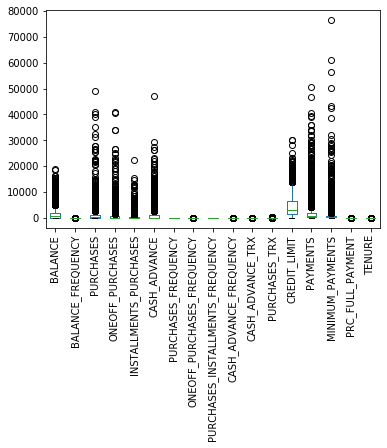

In [7]:
data.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

**Preliminary Data Preparation**

Missing value and Outlier treatment

In [8]:
data_all = data.copy()
data = data_all[data_all.columns.difference(['CUST_ID'])]

In [9]:
def outlier_miss_treat(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    x = x.fillna(x.median())
    return x

data = data.apply(outlier_miss_treat)

In [10]:
data.isnull().sum().value_counts()

0    17
dtype: int64

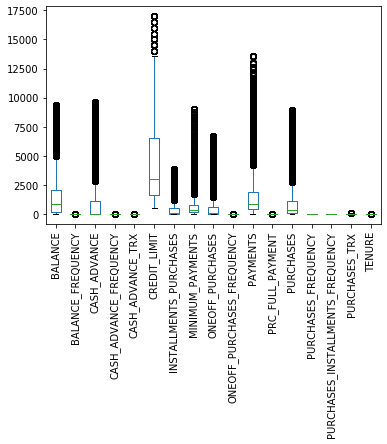

In [11]:
data.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

**Identifying the Key Performance Indicators**

Monthly Average Purchase

In [12]:
data['Monthly_avg_purchase']=data['PURCHASES']/data['TENURE']

Monthly cash advance

In [13]:
data['Monthly_cash_advance']=data['CASH_ADVANCE']/data['TENURE']

Limit usage

In [14]:
data['limit_usage']=data['BALANCE']/data['CREDIT_LIMIT']

In [15]:
data[['Monthly_avg_purchase','Monthly_cash_advance','limit_usage']].head(3)

,Monthly_avg_purchase,Monthly_cash_advance,limit_usage
0,7.950000,0.000000,0.040901
1,0.000000,536.912124,0.457495
2,64.430833,0.000000,0.332687


Purchase type

In [16]:
data['purchase_type'] = np.where(((data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']==0)),'none',
                                 (np.where(((data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']>0)),'both',
                                           (np.where(((data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']==0)),'one_off',
                                                     (np.where(((data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']>0)),'installment','x')))))))

In [17]:
data.purchase_type.value_counts()

both           2774
installment    2260
none           2042
one_off        1874
Name: purchase_type, dtype: int64

In [18]:
df = data[['purchase_type', 'Monthly_avg_purchase', 'Monthly_cash_advance', 'limit_usage' ]].groupby('purchase_type').mean()

In [19]:
df

,Monthly_avg_purchase,Monthly_cash_advance,limit_usage
purchase_type,,,
both,176.861350,62.972375,0.351471
installment,46.139936,36.722734,0.270450
none,0.000000,176.996706,0.563894
one_off,67.284704,76.770332,0.379007


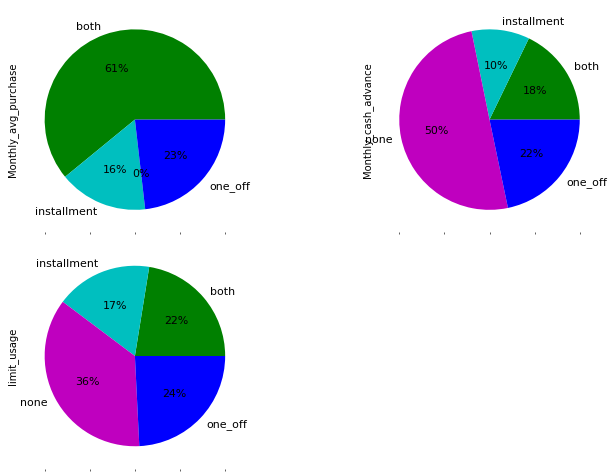

In [20]:
df.plot(kind='pie', 
            labels=['both', 'installment', 'none', 'one_off'], 
            colors=['g', 'c', 'm', 'b'],
            autopct='%1.0f%%',
            fontsize=11,
            subplots='true',
            layout=(3,2), #to get a grid
            figsize=(10,10),
            legend = False)

plt.tight_layout()
plt.show()

From the above plots the following insights are found, <br>

- Monthly average purchase <br>
High → both , Low → none <br>


- Monthly cash advance     <br>
High → none , Low → installment<br>


- Limit of usage           <br>
High → none , Low → installment

•	Average amount per purchase transaction
PURCHASES_TRX - given in the dataset

•	Average amount per cash-advance transaction
CASH_ADVANCE_TRX - given in the dataset

One hot encoding for purchase_type

In [21]:
pur_dum = pd.get_dummies(data.purchase_type,drop_first=True)

In [22]:
data.drop(columns = ['purchase_type'], inplace =True)

In [23]:
data = pd.concat([data,pur_dum],axis=1)

### Feature Reduction

#### Prinicipal Component analysis

**1 Splitting the dataset**

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.3, random_state=7)

In [25]:
train.shape , test.shape

((6265, 23), (2685, 23))

**2 Feature scaling**

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

fit() ------------------> just calculates the parameters (e.g. μ and σ in case of StandardScaler) <br>
transform() ------------> helps to apply the scaling based on the calculated parameters from fit()

In [27]:
train_scaled = sc.fit_transform(train) 

In [28]:
test_scaled = sc.transform(test)

**3 Applying PCA** 

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)

In [30]:
train_scaled = pca.fit_transform(train_scaled)

In [31]:
test_scaled = pca.transform(test_scaled)

**3.1** Eigen value

In [32]:
pca.explained_variance_

array([6.13604525e+00, 4.86580490e+00, 2.25158201e+00, 1.79620630e+00,
       1.20569289e+00, 1.18190204e+00, 9.81530308e-01, 7.71100379e-01,
       7.00844704e-01, 5.52044913e-01, 5.11803218e-01, 4.94694932e-01,
       3.36599334e-01, 3.02852720e-01, 2.39845512e-01, 2.09129365e-01,
       1.51329021e-01, 1.32769406e-01, 1.01827730e-01, 3.59307676e-02,
       2.03672096e-02, 1.85645540e-02, 5.20430342e-03])

**3.2** Variance explained by each PC in Cumulative Percentage 

In [33]:
np.cumsum(pca.explained_variance_ratio_)

array([0.26674199, 0.47826496, 0.5761442 , 0.65422766, 0.70664073,
       0.75801957, 0.80068799, 0.83420874, 0.86467539, 0.88867351,
       0.91092227, 0.93242731, 0.94705973, 0.96022514, 0.97065154,
       0.97974267, 0.98632114, 0.9920928 , 0.99651939, 0.99808135,
       0.99896674, 0.99977376, 1.        ])

**3.3** Selecting the Number of Principal components based on <br>
Cumulative percentage of variance > 75% <br>
Eigen value > 0.8

Based on the above criteria for selection we conclude **Number of PC = 8** 

**3.4** Fitting the model again with the select number PC

In [34]:
pca_final = PCA(n_components=8)

In [35]:
pca_final = pca_final.fit(train_scaled)

In [36]:
pca_final.explained_variance_

array([6.13604525, 4.8658049 , 2.25158201, 1.7962063 , 1.20569289,
       1.18190204, 0.9815303 , 0.77110031])

In [37]:
np.cumsum(pca_final.explained_variance_ratio_)

array([0.26674199, 0.47826496, 0.5761442 , 0.65422766, 0.70664073,
       0.75801957, 0.80068799, 0.83420874])

**3.5** Dimension Reduction 

In [38]:
# Applying the pca model on the scaled train data, which gives the array with specified number of PCs
reduced_factors = pca_final.transform(train_scaled) #----------->    this gives the factors

In [39]:
dimensions = pd.DataFrame(reduced_factors);
dimensions.head(2)

,0,1,2,3,4,5,6,7
0,-2.415149,-0.391026,0.402886,-1.416098,-1.652900,-0.981650,-0.485591,-0.026382
1,-0.421227,1.074602,0.188434,0.243009,0.205871,-0.001368,-0.553960,0.200778


**3.6** Factor Loading Matrix / Component loadings

Loadings=Eigenvectors * sqrt(Eigenvalues)

Factor loadings are the covariances/correlations between the original variables and the unit-scaled components. (i.e., PCs ~ Initial Columns ) <br>

Factors Loadings are the percent of variance in a variable explained by the factor

In [40]:
eigen_vector = pca_final.components_.T

In [41]:
eigen_value = pca_final.explained_variance_

In [42]:
Factor_loading_matrix = pd.DataFrame((eigen_vector * np.sqrt(eigen_value)).T,columns=train.columns).T

In [43]:
Factor_loading_matrix;

In [44]:
#Factor_loading_matrix.to_excel('Factor_Loading_matrix_segment.xlsx')

**3.7** Selecting the Features based on the factor loadings

In [45]:
selected_vars_pca = ['BALANCE','BALANCE_FREQUENCY','CASH_ADVANCE','CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX',
                     'CREDIT_LIMIT','INSTALLMENTS_PURCHASES','MINIMUM_PAYMENTS']

In [46]:
train_all = train.copy()
train = train_all[selected_vars_pca]

In [47]:
test_all = test.copy()
test = test_all[selected_vars_pca]

---

### Finding the Optimum # Clusters

> Elbow method <br>
> Silhouette Analysis

**Elbow Method**

In [48]:
import matplotlib.pyplot as plt

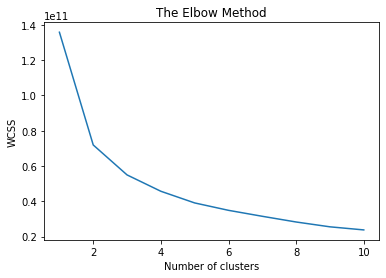

In [49]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 7)
    kmeans.fit(train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the above plot, the optimum number of clusters is found to be 3

**Silhouette Analysis**

In [50]:
from  sklearn import metrics

In [51]:
# calculate SC for K=1 through K=10
k_range = range(2, 10)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=7)
    km.fit(train)
    scores.append(metrics.silhouette_score(train, km.labels_))

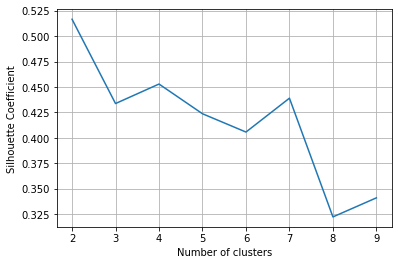

In [52]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

The Silhouette value is high for the #3, #4 and #7 cases.

From the above two methods, It is found that the data can be well segmented if the number of clusters is either 3 or 4.

### Model Implementation

#3 Clusters

In [53]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_scaled = sc.fit_transform(train) 
test_scaled = sc.transform(test)

In [54]:
kmeans_3 = KMeans(n_clusters = 3, random_state = 7)

y_km_3 = kmeans_3.fit_predict( train_scaled )

#4 Clusters

In [55]:
kmeans_4 = KMeans(n_clusters = 4, random_state = 7)

y_km_4 = kmeans_4.fit_predict( train_scaled )

#7 Clusters

In [56]:
kmeans_7 = KMeans(n_clusters = 7, random_state = 7)

y_km_7 = kmeans_7.fit_predict( train_scaled )

---

In [57]:
train_all['cluster_3'] = y_km_3
train_all['cluster_4'] = y_km_4
train_all['cluster_7'] = y_km_7

### Profiling

size

In [61]:
size = pd.concat([pd.Series(train_all.cluster_3.size), 
                  pd.Series.sort_index(train_all.cluster_3.value_counts()),
                  pd.Series.sort_index(train_all.cluster_4.value_counts()), 
                  pd.Series.sort_index(train_all.cluster_7.value_counts())])     

In [62]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_size.T

,0,0,1,2,0,1,2,3,0,1,2,3,4,5,6
Seg_size,6265,1143,972,4150,448,3879,977,961,108,941,2974,944,361,498,439


In [63]:
Seg_Percent = pd.DataFrame(size/train_all.cluster_3.size, columns=['Seg_Pct'])
Seg_Percent.T

,0,0,1,2,0,1,2,3,0,1,2,3,4,5,6
Seg_Pct,1.0,0.182442,0.155148,0.66241,0.071508,0.619154,0.155946,0.153392,0.017239,0.1502,0.474701,0.150678,0.057622,0.079489,0.070072


In [64]:
P1 = pd.concat([Seg_size.T, Seg_Percent.T], axis=0)

In [65]:
P1

,0,0,1,2,0,1,2,3,0,1,2,3,4,5,6
Seg_size,6265.0,1143.000000,972.000000,4150.00000,448.000000,3879.000000,977.000000,961.000000,108.000000,941.0000,2974.000000,944.000000,361.000000,498.000000,439.000000
Seg_Pct,1.0,0.182442,0.155148,0.66241,0.071508,0.619154,0.155946,0.153392,0.017239,0.1502,0.474701,0.150678,0.057622,0.079489,0.070072


Mean

In [66]:
O_mean = train_all.apply(lambda x: x.mean()).T

In [67]:
P2 = pd.concat([O_mean, 
           train_all.groupby('cluster_3').apply(lambda x: x.mean()).T, 
           train_all.groupby('cluster_4').apply(lambda x: x.mean()).T,
           train_all.groupby('cluster_7').apply(lambda x: x.mean()).T],
         axis=1)

In [68]:
P2.head(3)

,0,0,1,2,0,1,2,3,0,1,2,3,4,5,6
BALANCE,1532.135574,4275.502787,123.755776,1106.419054,4541.145175,988.767605,3698.413811,120.308535,3916.700626,117.767012,821.258738,1762.010298,4885.862962,1523.832013,5550.298103
BALANCE_FREQUENCY,0.879232,0.971198,0.386522,0.969304,0.991822,0.967849,0.963020,0.383867,0.988870,0.381247,0.966861,0.954100,0.967606,0.969953,0.989481
CASH_ADVANCE,919.204605,3575.561828,331.501215,325.236265,795.395306,327.771571,3918.255617,315.211334,819.366614,300.301512,182.834081,1905.040846,5898.056308,261.079104,1791.386554


Profile Output

In [69]:
Profiling_output = pd.concat([P1,P2], axis=0)

In [70]:
Profiling_output.columns = ['Overall', 'KM3_1', 'KM3_2','KM3_3','KM4_1','KM4_2','KM4_3','KM4_4','KM7_1','KM7_2','KM7_3','KM7_4','KM7_5','KM7_6','KM7_7']

In [71]:
#Profiling_output.to_excel('Profile_output_seg.xlsx')

### Insights and marketting strategy

**3 Clusters**

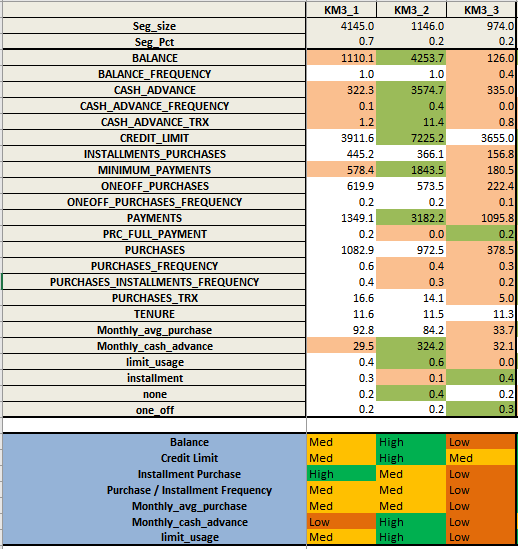

**Insights and type of marketting strategy**<br>
Cluster 1: Spender - Good<br>
Cluster 2: Passive - Target <br>
Cluster 3: Spends more with low balance - Good

---

**4 Clusters**

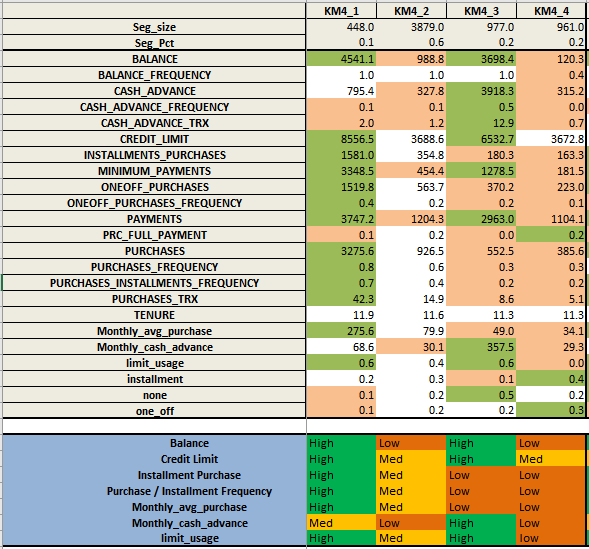

**Insights and type of marketting strategy**<br>
Cluster 1: Spender - Good<br>
Cluster 2: Spender - Good <br>
Cluster 3: Passive - Target<br>
Clsuter 4: Retiring - Risky

**7 Clusters**

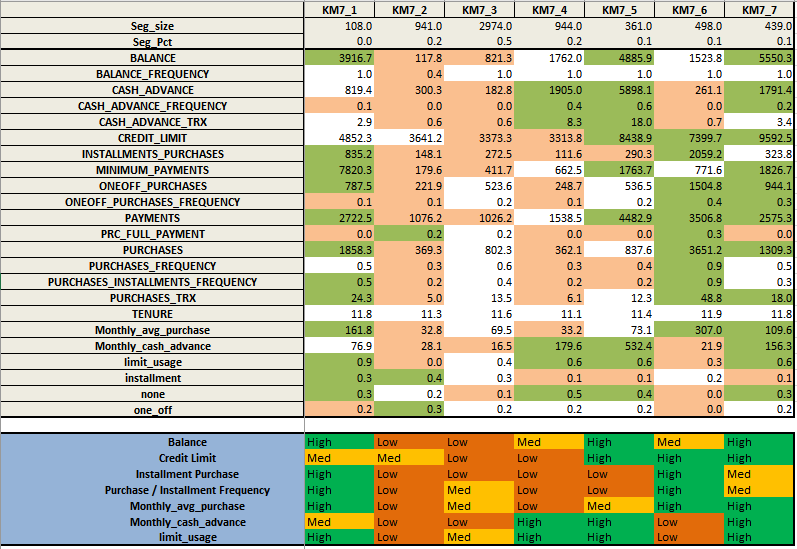

### ---------------------------------------------------------------------------------------------------------------------------